# Table of Contents
 <p><div class="lev1 toc-item"><a href="#try-fitting-lorentzian-to-the-amplitude-ramp-up" data-toc-modified-id="try-fitting-lorentzian-to-the-amplitude-ramp-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>try fitting lorentzian to the amplitude ramp-up</a></div>

In [655]:
# env source /Users/sebastian/work/git/stk/ml/waveforms/venv-wf/bin/activate

In [656]:
import sys
sys.path.append("../nonspin/")

In [657]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from waveform import SingleModeNRWaveform

In [658]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [659]:
# 1./p1.fdamp/2/np.pi
#11.706422641558191

In [660]:
# 1./p10.fdamp/2/np.pi
#11.272552160962043

In [661]:
# load data

# nrfiles = [
#     '/Users/sebastian/work/data/SXS_BBH_0071_Res5.h5', #q=1
#     '/Users/sebastian/work/data/SXS_BBH_0169_Res5.h5', #q=2
#     '/Users/sebastian/work/data/SXS_BBH_0168_Res5.h5', #q=3
#     '/Users/sebastian/work/data/SXS_BBH_0167_Res5.h5' #q=4
# ]

# nrfiles = [
#     '/Users/sebastian/work/data/SXS_BBH_0071_Res5.h5', #q=1
#     '/Users/sebastian/work/data/SXS_BBH_0169_Res5.h5', #q=2
#     '/Users/sebastian/work/data/SXS_BBH_0167_Res5.h5', #q=4
#     '/Users/sebastian/work/data/SXS_BBH_0107_Res5.h5', #5
#     '/Users/sebastian/work/data/SXS_BBH_0303_Res5.h5' #10
# ]

nrfiles = [
        '/Users/sebastian/work/data/SXS_BBH_0107_Res5.h5', #5
        '/Users/sebastian/work/data/SXS_BBH_0303_Res5.h5', #10
    '/Users/sebastian/work/data/SXS_BBH_0169_Res5.h5', #q=2
    '/Users/sebastian/work/data/SXS_BBH_0167_Res5.h5', #q=4

    '/Users/sebastian/work/data/SXS_BBH_0071_Res5.h5' #q=1
]



In [662]:
# q1 = SingleModeNRWaveform(nrfiles[0], 2, 2, 1000)

ell = 2
mm = 2

npts_time = 1000
npts_mass_ratio = len(nrfiles)

# t1=None
# t2=None
t1=-600
t2=80

nrdata = [SingleModeNRWaveform(nrfile, ell, mm, npts_time,t1=t1,t2=t2) for nrfile in nrfiles]

In [663]:
class Psi4(object):
    """
    stores Psi4 data aligned such that the peak of Psi4 is at t=0
    """
    def __init__(self, nrfile, ell, mm, npts_time, t1, t2):
        self.nrfile = nrfile
        self.ell = ell
        self.mm = mm
        self.npts_time = npts_time
        self.t1 = t1
        self.t2 = t2
        self.nrdata = SingleModeNRWaveform(self.nrfile, self.ell, self.mm, self.npts_time,t1=self.t1,t2=self.t2)
        
        ihlmre = IUS(self.nrdata.times, self.nrdata.hlm.real)
        ihlmim = IUS(self.nrdata.times, self.nrdata.hlm.imag)

        psi4lmre = ihlmre.derivative().derivative()(self.nrdata.times)
        psi4lmim = ihlmim.derivative().derivative()(self.nrdata.times)

        self.psi4lm = psi4lmre - 1.j*psi4lmim
        
        # index of maximum
        max_idx = np.abs(self.psi4lm).argmax()
        # time of maximum
        self.time_at_max_idx = self.nrdata.times[max_idx]
        
        self.times = self.nrdata.times - self.time_at_max_idx
        
        
        
        self.psi4lm_phase = np.unwrap(np.angle(self.psi4lm))
        i_psi4lm_phase = IUS(self.times, self.psi4lm_phase)
        self.psi4lm_ang_freq = i_psi4lm_phase.derivative()(self.times)
        
        

        eta, chi1z, chi2z = self.nrdata.eta, 0., 0.
        self.fin_spin = phenom.remnant.FinalSpin0815(eta, chi1z, chi2z)
        self.fring = phenom.remnant.fring(eta, chi1z, chi2z, self.fin_spin)
        self.fdamp = phenom.remnant.fdamp(eta, chi1z, chi2z, self.fin_spin)
        self.final_mass = 1.0 - phenom.EradRational0815(eta, chi1z, chi2z)
        
#         self.ang_f_22_isco = phenom.HztoMf(f_SchwarzISCO(self.final_mass), self.final_mass)

        m1 = mass1_from_mtotal_eta(1., eta)
        m2 = mass2_from_mtotal_eta(1., eta)
        self.hyb_meco_ang_freq = phenom.HztoMf(hybrid_meco_frequency(m1, m2, chi1z, chi2z), self.final_mass) * 2 * np.pi

        # get from TaylorT3 orb frequency: https://arxiv.org/abs/0901.2437
#         leading_order = 2
        

In [664]:
# I need the ISCO frequency of the final BH
from pycbc.conversions import mass1_from_mtotal_eta, mass2_from_mtotal_eta
from pycbc.pnutils import f_SchwarzISCO, hybrid_meco_frequency

In [665]:
import phenom

In [666]:
psi4_data = Psi4(nrfiles[0], ell, mm, npts_time,t1=t1,t2=t2)

In [667]:
# compare q=1 and q=10 cases

In [668]:
p1 = Psi4('/Users/sebastian/work/data/SXS_BBH_0071_Res5.h5', ell, mm, npts_time,t1=t1,t2=t2)
p10 = Psi4('/Users/sebastian/work/data/SXS_BBH_0303_Res5.h5', ell, mm, npts_time,t1=t1,t2=t2)

In [669]:
p1.hyb_meco_ang_freq

0.14651650447561185

In [670]:
p10.hyb_meco_ang_freq

0.1404177878073284

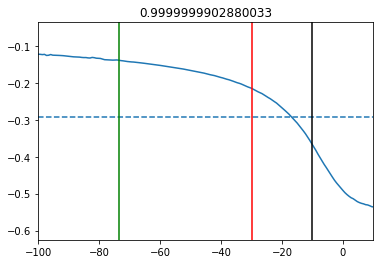

In [671]:
plt.figure()
plt.plot(p1.times, p1.psi4lm_ang_freq)
plt.axhline(-p1.hyb_meco_ang_freq*2, ls='--')
# plt.axhline(-p1.hyb_meco_ang_freq*1./np.sqrt(1./8), ls='--')
plt.title(p1.nrdata.q)
plt.xlim(-100,10)
plt.axvline(-30, c='r')
plt.axvline(-10, c='k')
plt.axvline(-1./p1.fdamp, c='g')

In [672]:
p1.nrdata.eta

0.25

In [673]:
p10.nrdata.eta

0.08264502420740191

In [674]:
p1.nrdata.eta/p10.nrdata.eta

3.0249855015180613

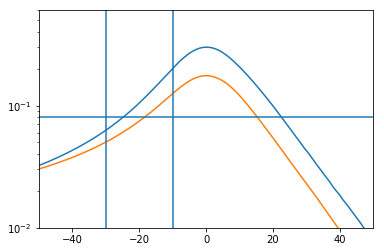

In [675]:
plt.figure()
plt.plot(p1.times, np.abs(p1.psi4lm) / p1.nrdata.eta)
plt.plot(p10.times, np.abs(p10.psi4lm) / p10.nrdata.eta)
plt.yscale('log')
plt.xlim(-50, 50)
plt.ylim(0.01,0.6)
plt.axhline(0.08)
plt.axvline(-30)
plt.axvline(-10)

(-50, 50)

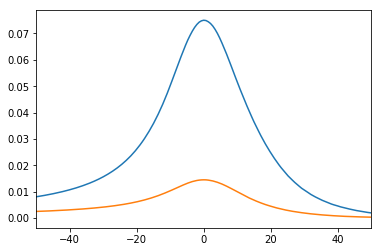

In [676]:
plt.figure()
plt.plot(p1.times, np.abs(p1.psi4lm))
plt.plot(p10.times, np.abs(p10.psi4lm))
# plt.yscale('log')
plt.xlim(-50, 50)

In [677]:
1./np.sqrt(1./8)

2.82842712474619

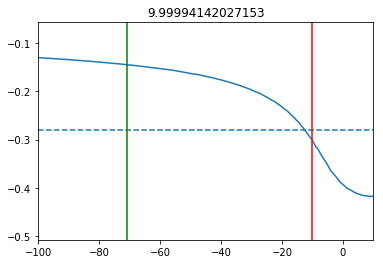

In [678]:
plt.figure()
plt.plot(p10.times, p10.psi4lm_ang_freq)
plt.axhline(-p10.hyb_meco_ang_freq*2, ls='--')
# plt.axhline(-p10.hyb_meco_ang_freq*1./np.sqrt(1./8), ls='--')
plt.title(p10.nrdata.q)
plt.xlim(-100,10)

plt.axvline(-10, c='r')

plt.axvline(-1./p10.fdamp, c='g')

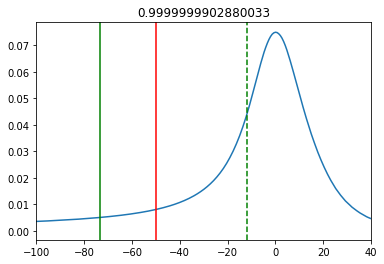

In [679]:
plt.figure()
plt.plot(p1.times, np.abs(p1.psi4lm))
plt.title(p1.nrdata.q)
plt.xlim(-100,40)

plt.axvline(-50, c='r')

plt.axvline(-1./p1.fdamp, c='g')
plt.axvline(-1./p1.fdamp/2/np.pi, c='g', ls='--')

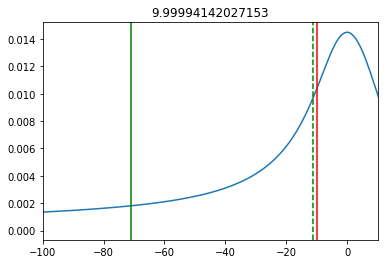

In [680]:
plt.figure()
plt.plot(p10.times, np.abs(p10.psi4lm))
plt.title(p10.nrdata.q)
plt.xlim(-100,10)

plt.axvline(-10, c='r')

plt.axvline(-1./p10.fdamp, c='g')
plt.axvline(-1./p10.fdamp/2/np.pi, c='g', ls='--')

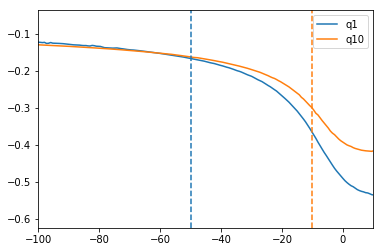

In [681]:
plt.figure()
plt.plot(p1.times, p1.psi4lm_ang_freq, label='q1', c='C0')
plt.plot(p10.times, p10.psi4lm_ang_freq, label='q10', c='C1')
plt.xlim(-100,10)
# plt.ylim(-0.01,0.1)

plt.axvline(-50, c='C0', ls='--')
plt.axvline(-10, c='C1', ls='--')
plt.legend()

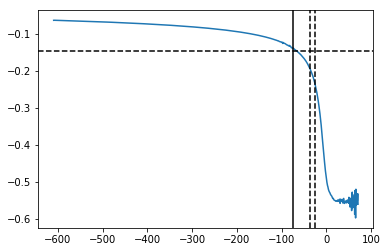

In [682]:
plt.figure()
plt.plot(p1.times, p1.psi4lm_ang_freq)
# plt.axhline(-Mf_22_isco*2*np.pi, c='k')
# plt.axhline(-2*Mf_22_isco*2*np.pi, c='k', ls='--')
plt.axhline(-p1.hyb_meco_ang_freq, c='k', ls='--')
plt.axvline(-1./p1.fdamp, c='k')
plt.axvline(-1./p1.fdamp/2, c='k', ls='--')
plt.axvline(-1./p1.fdamp/3, c='k', ls='--')

In [683]:
p1.time_at_max_idx

9.209209209209234

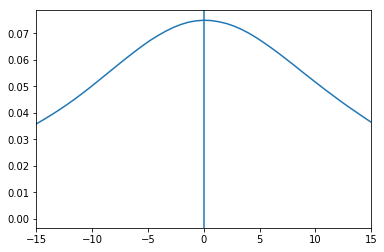

In [684]:
plt.figure()
plt.plot(p1.times, np.abs(p1.psi4lm))
plt.xlim(-15,15)
plt.axvline(0)

(-50, 50)

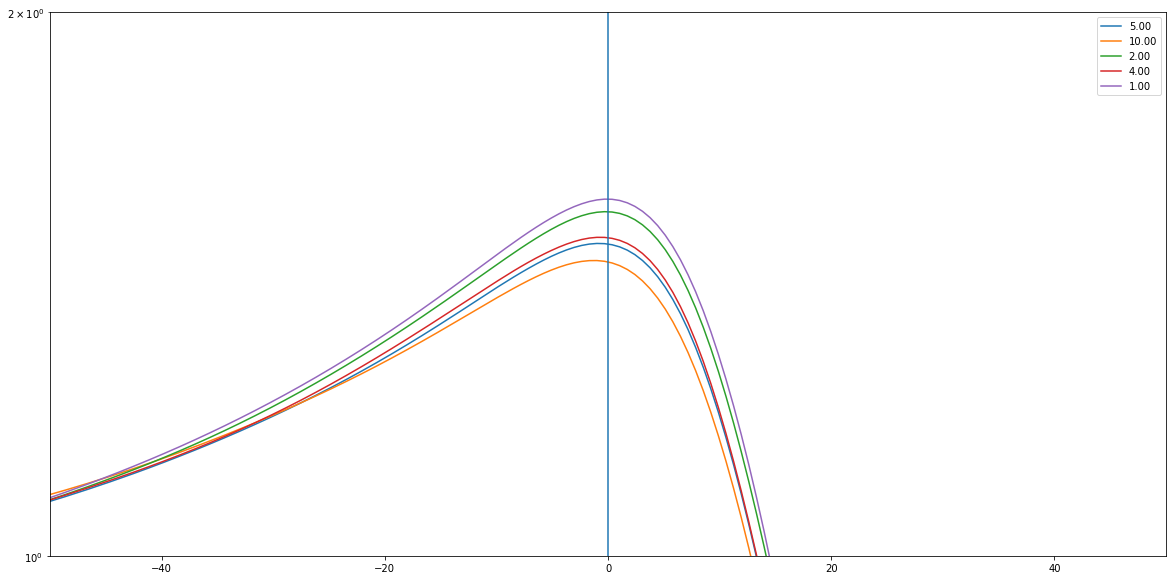

In [685]:
plt.figure(figsize=(20,10))
for nr in nrdata:
#     plt.plot(nr.times, nr.amp/nr.eta, label=nr.nrfile.split('/')[-1].split('.h5')[0])
    plt.plot(nr.times, nr.amp/nr.eta, label="{:.2f}".format(nr.q))
plt.legend()
# plt.xlim(-10,20)
plt.yscale('log')
# plt.ylim(0.5,2)
plt.ylim(1,2)
plt.axvline(0)
plt.xlim(-50, 50)

# try fitting lorentzian to the amplitude ramp-up

In [703]:
from scipy.optimize import least_squares

def fun_lor(x, t, y=0.):
    
    
#     model = (x[0]*x[2]) / ( (t-x[1])**2 + x[0]**2 )
    model = (x[0]*x[2]) / ( (t-x[1])**2 + x[0]**2 ) + x[3]/(t-x[1]) + x[4]/(t-x[1])**2
    
#     model = (70.82*x[2]) / ( (t-x[1])**2 + 70.82**2 ) + x[3]/(t-x[1]) # fixing the damping time as the width.
    
    
    
    
#     model = (x[0]*x[2]) / ( (t-x[1])**2 + x[0]**2 ) + x[3]/(t-x[1]) + x[4]/(t-x[1])**2.
#     model = (x[0]*x[2]) / ( (t-x[1])**2 + x[0]**2 ) + x[3]/(t-x[1]) + x[4]/(t-x[1])**2. + x[5]/(t-x[1])**3.
    
    
    # poly
#     model = x[0] + x[1]/(t-x[2]) + x[2]/(t-x[2])**2
    
    return (model) - y


# mask = (nrdata[0].times > -400) & (nrdata[0].times < -8)
# mask = (nrdata[0].times > -300) & (nrdata[0].times < -4)
# mask = (nrdata[0].times > -100) & (nrdata[0].times < -4)
# mask = (nrdata[0].times > -400) & (nrdata[0].times < -100) # for poly
# mask = (nrdata[0].times > -600) & (nrdata[0].times < -100) # for poly


# mask = (nrdata[0].times > -600) & (nrdata[0].times < -50) # use this for equal mass
# mask = (nrdata[0].times > -600) & (nrdata[0].times < -10) # use this for high mass-ratio
# mask = (nrdata[0].times > -600) & (nrdata[0].times < -20) # seems to work for all cases


# mask = (psi4_data.times > -600) & (psi4_data.times < -30)
# mask = (psi4_data.times > -600) & (psi4_data.times < -35 * psi4_data.nrdata.eta/0.25)

# mask = (psi4_data.times > -300) & (psi4_data.times < -60) 

# mask = (psi4_data.times > -600) & (psi4_data.times < -30) # seems to work for all cases
# mask = (psi4_data.times > -400) & (psi4_data.times < 3 * -1./psi4_data.fdamp/2/np.pi) # seems to work for all cases


mask = (psi4_data.times > -600) & (psi4_data.times < -5)
# mask = (psi4_data.times > -600) & (psi4_data.times < -15) # this works for all if you have quadratic extension

t_train_lor = psi4_data.times[mask]
# y_train_lor = np.abs(psi422[mask])**2
y_train_lor = np.abs(psi4_data.psi4lm[mask])

# scale by eta
# y_train_lor = np.abs(psi4_data.psi4lm[mask]) / psi4_data.nrdata.eta


# x0 = np.array([20.0, 1.0,20])
# x0 = np.array([20.0, 1.0,20,1])
# x0 = np.array([20.0, 1.0,20,1,1])
# x0 = np.array([20.0, 1.0,20,np.random.rand(),np.random.rand()])
# x0 = np.array([20.0, 1.0,20,np.random.rand(),np.random.rand(),np.random.rand()])
# x0 = np.array([20.0, 1.0,20,np.random.rand(),np.random.rand()])
x0 = np.array([20.0, 1.0,20,np.random.rand(),np.random.rand(),np.random.rand()])
res_lor_lsq = least_squares(fun_lor, x0, args=(t_train_lor, y_train_lor))

In [704]:
psi4_data.nrdata.eta

0.13888911125870543

In [705]:
-1./psi4_data.fdamp/2/np.pi/0.25

-45.31722784799572

In [706]:
-35 * psi4_data.nrdata.eta/0.25

-19.44447557621876

In [707]:
res_lor_lsq.x

array([37.68717672, 34.83854721, -2.30900078, -0.30357063, 77.18124957,
        0.68122158])

In [708]:
1./p10.fdamp

70.8275341121722

In [709]:
-1./psi4_data.fdamp/2/np.pi


-11.32930696199893

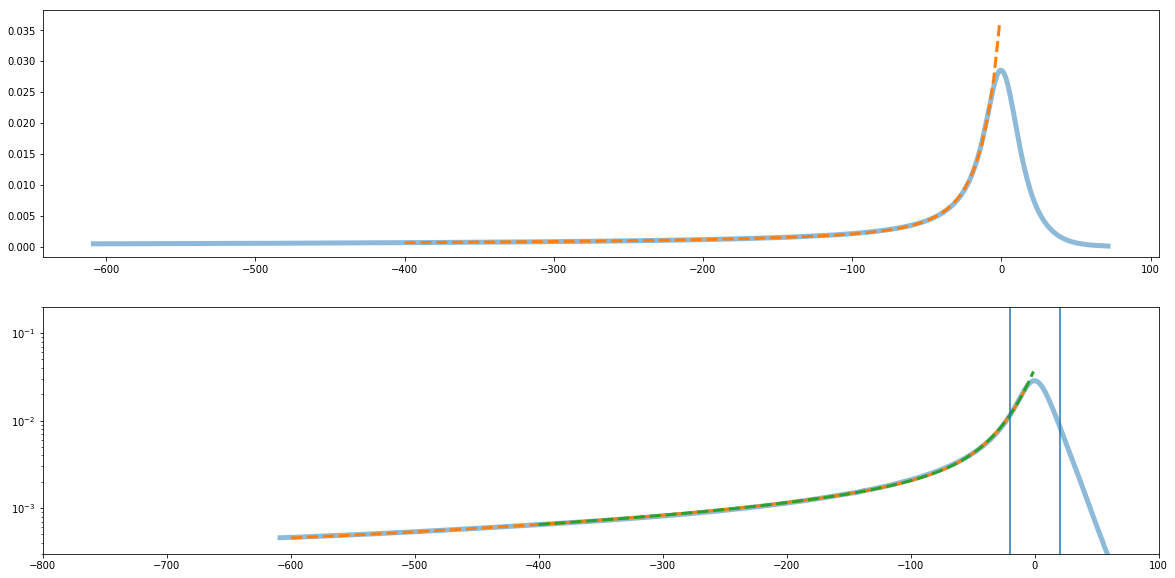

In [710]:
fig, axes = plt.subplots(2,1, figsize=(20,10))

axes[0].plot(psi4_data.times, np.abs(psi4_data.psi4lm), lw=5, alpha=0.5)
axes[1].plot(psi4_data.times, np.abs(psi4_data.psi4lm), lw=5, alpha=0.5)


# fit regions
axes[1].plot(t_train_lor, fun_lor(res_lor_lsq.x, t_train_lor, 0) , lw=3, ls='--')

# extrapolated regions

lor_times_extrap = np.linspace(-400, -1, 100)
axes[0].plot(lor_times_extrap, fun_lor(res_lor_lsq.x, lor_times_extrap, 0)  , lw=3, ls='--')
axes[1].plot(lor_times_extrap, fun_lor(res_lor_lsq.x, lor_times_extrap, 0)  , lw=3, ls='--')


# axes[1].set_xlim(-500,100)
axes[1].set_xlim(-800,100)
# plt.xlim(-20,100)
axes[1].set_yscale('log')
# axes[1].set_ylim(1e-7,2e-1)
axes[1].set_ylim(3e-4,2e-1)

axes[1].axvline(-20)
axes[1].axvline(20)



In [711]:
# end time goes from 1./f_damp for mass-ratio 10 and is 3 * 1./f_damp for equal mass